"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import numpy as np
from scipy.stats import poisson
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
import visualize as vz

In [2]:
def var_sig_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-b*x))

def var_sig_exp_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-np.exp(b)*x))


In [3]:
max_x = 20
x = np.linspace(0,max_x,100)
idx = np.arange(len(x))
states = 3
nrns = 7
trials = 10


# #b = [20,1]
# b = [20,1]#stats.norm.rvs(0,2, size=states-1)
# inflect = [-3,5]
# min_val = stats.expon.rvs(10, size=nrns)#3
# val_diff = stats.norm.rvs(0,30,size=(nrns,states-1))#[40,-20]

#b = [20,1]
b = [20,1]#stats.norm.rvs(0,2, size=states-1)
inflect = np.random.random((trials, states-1))*max_x#[-3,5]
min_val = stats.expon.rvs(10, size=nrns)#3
val_diff = stats.norm.rvs(0,30,size=(nrns,states-1))#[40,-20]

def gen_nrn(min_val, diff, inflect, b):
    rate = np.ones(len(x))*min_val
    for this_b, this_diff, this_inflect in zip(b,diff,inflect):
         rate += var_sig_np(x-this_inflect,this_b)*this_diff
    return rate


def gen_trial(min_val, val_diff, inflect, b):
    rate = []
    for i in range(nrns):
        this_min = min_val[i]
        this_diff = val_diff[i]
        rate.append(gen_nrn(this_min, this_diff, inflect, b))
    rate = np.stack(rate)
    return rate

rate = []
for i in range(trials):
    rate.append(
            gen_trial(min_val, val_diff, inflect[i], b)
    )
rate = np.stack(rate)
        
rate[rate<0] = 0
rate+=0.1
data_vec = poisson.rvs(rate)

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


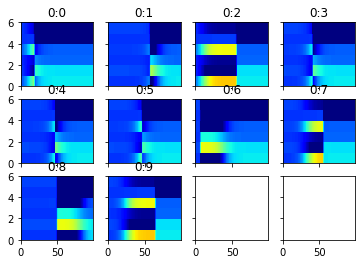

In [4]:
vz.firing_overview(rate);

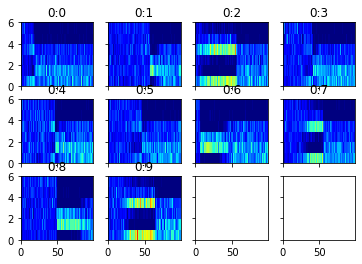

In [5]:
vz.firing_overview(data_vec);

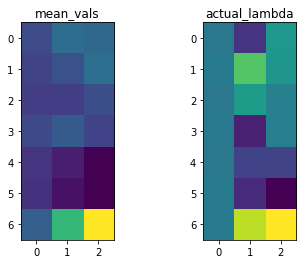

In [13]:
actual_lambda = np.cumsum(np.concatenate([min_val[:,None],val_diff],axis=-1),axis=-1)
mean_vals = np.mean([np.mean(x,axis=-1) for x in np.array_split(data_vec,states,axis=-1)],axis=1).T
mean_vals += 0.01  # To avoid zero starting prob
#mean_vals.shape
#print(mean_vals)
fig,ax = plt.subplots(1,2)
ax[0].imshow(mean_vals);
ax[1].imshow(actual_lambda);
ax[0].set_title('mean_vals');
ax[1].set_title('actual_lambda');
# plt.show()

In [14]:
def var_sig_exp_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-tt.exp(b)*x))

def var_sig_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-b*x))

lambda_test_vals = np.diff(mean_vals, axis=-1)
even_switches = np.linspace(0,1,states+1)[1:-1]

In [15]:
with pm.Model() as model:
      
    # Sigmoid slope
    sig_b = pm.Normal('sig_b', -1,2, shape = states-1)
    
    # Initial value
    s0 = pm.Exponential('state0', 
                        1/(np.mean(mean_vals)),
                        shape = nrns,
                        testval = mean_vals[:,0])
    
    # Changes to lambda
    lambda_diff = pm.Normal('lambda_diff', 
                            mu = 0, sigma = 10, 
                            shape = (nrns,states-1), 
                            testval = lambda_test_vals)
    
    # Changepoint positions
    a = pm.HalfCauchy('a_tau', 10, shape = states - 1)
    b = pm.HalfCauchy('b_tau', 10, shape = states - 1)
    
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials, states-1)).sort(axis=-1)    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Mechanical manipulations to generate firing rates
    idx_temp = np.tile(idx[None,None,:], (trials, states-1,1))
    tau_temp = tt.tile(tau[:,:,None], (1,1,len(idx)))
    sig_b_temp = tt.tile(sig_b[None,:,None], (trials,1,len(idx)))

    weight_stack = var_sig_exp_tt(idx_temp-tau_temp,sig_b_temp)
    weight_stack_temp = tt.tile(weight_stack[:,None,:,:], (1,nrns,1,1))

    s0_temp = tt.tile(s0[None,:,None,None], (trials,1,states-1, len(idx)))
    lambda_diff_temp = tt.tile(lambda_diff[None,:,:,None], (trials,1,1, len(idx)))

    # Calculate lambda
    lambda_ =  pm.Deterministic('lambda_',
                    tt.sum(s0_temp + (weight_stack_temp*lambda_diff_temp),axis=2))
    # Bound lambda to prevent the diffs from making it negative
    lambda_bounded = pm.Deterministic("lambda_bounded", tt.switch(lambda_>=0, lambda_, 0))
    
    # Add observations
    observation = pm.Poisson("obs", lambda_bounded, observed=data_vec)

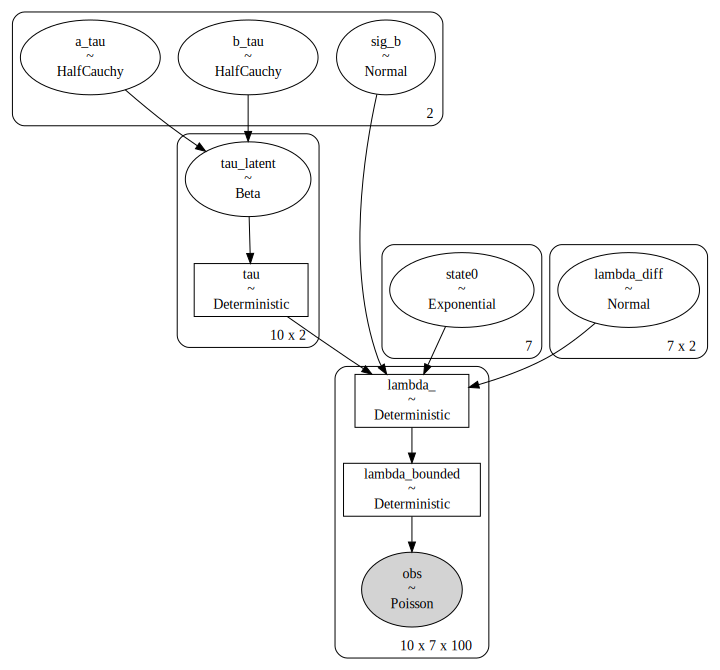

In [16]:
pm.model_to_graphviz(model)

In [17]:
samples = 20000
with model:    
    # If using MCMC, set n_cores = 1 (or whatever the parameter is) to make
    # sure there are no parallelization issues
    sampler_kwargs = {'cores' :1, 'chains':4}
    trace = pm.sample(draws=samples, **sampler_kwargs)
    trace = trace[::10]

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [tau_latent, b_tau, a_tau, lambda_diff, state0, sig_b]


Sampling 1 chain for 1_000 tune and 1_920 draw iterations (1_000 + 1_920 draws total) took 104 seconds.
There were 1813 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
pm.autocorrplot(trace);

In [ ]:
with model:
    pm.traceplot(trace, varnames = ['tau', 'state0', 'lambda_diff', 'sig_b'])

In [ ]:
for x in trace['sig_b'].T:
    plt.hist(x,50, alpha=0.5, density=True);
#np.mean(trace['sig_b'])

In [ ]:
np.power(10,np.mean(trace['sig_b'],axis=0))

In [ ]:
np.power(10,np.diff(np.mean(trace['sig_b'],axis=0)))

In [ ]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
mean_ppc = np.mean(ppc['obs'],axis=0)

In [ ]:
# fig,ax = plt.subplots(1,2,sharey=True)
# ax[0].plot(rate)
# ax[1].plot(np.mean(ppc['obs'],axis=0), alpha=1)
# ax[0].set_title('True r')
# ax[1].set_title('Mean prediction')

In [ ]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
mode_tau

In [ ]:
vz.firing_overview(rate);

In [ ]:
ax = vz.firing_overview(data_vec)
for this_ax, this_mode_tau in zip(ax.flatten(), mode_tau):
    for this_val in this_mode_tau:
        this_ax.axvline(this_val, color = 'red')

In [ ]:
vz.firing_overview(mean_ppc);

In [ ]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(10,10))
#ax[0].imshow(rate, interpolation='nearest', aspect='auto')
ax[0].plot(rate.T)
ax[0].set_ylabel('True r')
#ax[1].imshow(np.mean(ppc['obs'],axis=0), interpolation='nearest', aspect='auto')
ax[1].plot(.T)
ax[2].imshow(data_vec, interpolation='nearest', aspect='auto')
    
for tau_num, this_tau in enumerate(tau.T):
    ax[3].hist(this_tau,bins=50)
    ax[0].axvline(mode_tau[tau_num],color='red',alpha=0.5,linewidth=5)
